<a href="https://colab.research.google.com/github/uranchung/K-S2S-for-Extreme/blob/uranchung-patch-1/251111_Plot_t2m_w3_90th_freq_intensity_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plot Anomalously High Temperature**


**[90퍼센타일을 초과하는 날에 대한 평년 빈도 및 평년 강도 맵]**

자료 1과 2: ECMWF Hindcast의 버전 2016과 버전 2024의 초기 날짜(forecast issued date) 기반으로 90퍼센타일을 초과하는 이상 발생 정보, 예를 들면, 90퍼센타일을 초과하는 날에 대한 평년 빈도 및 평년 강도를 계산해서 (맵으로) 표출했다.

**You will need to mount your Google Drive to practice.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mount_Dir = '/content/gdrive/My Drive/Colab Notebooks/'
print(mount_Dir)

/content/gdrive/My Drive/Colab Notebooks/


In [ ]:
main_Dir = mount_Dir + 'Extreme_ECMWF_SK/'
print(main_Dir)

/content/gdrive/My Drive/Colab Notebooks/Extreme_ECMWF_SK/


* need install **cartopy**

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 90.3 MB/s eta 0:00:00


* then, to read & open nc files in CoLab, you'll first need to import the **xarray**, **numpy**, erc libraries.

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
## nc file path
input_file = xr.open_dataset(main_Dir + 'S2S_ECMWF_hindcast_T2M_w3_nb-mean_2004-2023.nc')
threshold_file = xr.open_dataset(main_Dir + 'S2S_ECMWF_hindcast_T2M_w3_clim90th.nc')

In [ ]:
## define out path
out_path = main_Dir
out_fileName = out_path + 'plot_v2024_t2m_90th_frequency_test.png'

In [ ]:
# read nc
t2m = input_file['t2m']
threshold = threshold_file['t2m_clim90th']

In [ ]:
# 날짜 기반 day-of-year 생성
t2m = t2m.assign_coords(doy=("time", t2m['time'].dt.dayofyear.data))

In [ ]:
# 7일 설정
t2m_window = t2m.rolling(time=7, center=True).mean()
# threshold(doy, lat, lon)과 같은 doy의 값을 대응시킴
t2m_match = t2m_window.groupby('doy')

**발생 빈도**

In [ ]:
# 각 날짜의 threshold 초과 여부 (True=1)
exceed = t2m_match - threshold
exceed_mask = (exceed > 0).astype(int)

In [ ]:
# 연도별로 초과 일수 계산
yearly_exceed = exceed_mask.groupby('time.year').sum(dim='time')
# 연평균 빈도 계산
freq = yearly_exceed.mean(dim='year')

In [ ]:
# 관심 영역 선택
freq_sub = freq.sel(latitude=slice(48, 21), longitude=slice(114, 141))

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


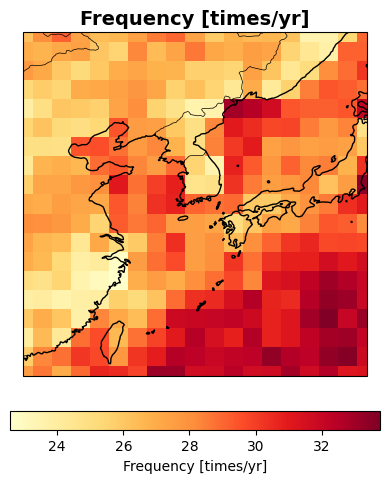

In [ ]:
# Plot: 발생 빈도
plt.figure(figsize=(4,5))
proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)
im = freq_sub.plot(
    ax=ax,
    transform=proj,
    cmap='YlOrRd',  # YlGnBu
    #vmin=20, vmax=55,
    cbar_kwargs={
        'label': 'Frequency [times/yr]',
        'orientation': 'horizontal',  # 가로로
        'pad': 0.08                   # 아래쪽 여백 (기본값 0.05 → 약간 아래로)
    }
)
ax.coastlines(resolution='50m', linewidth=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([114, 141, 21, 48], crs=proj)
ax.set_title('Frequency [times/yr]', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(out_fileName, dpi=300, bbox_inches='tight')
plt.show()

**발생 강도**

In [ ]:
out_fileName2 = out_path + 'plot_v2024_t2m_90th_intensity_test.png'

In [ ]:
threshold_match = threshold.sel(doy=t2m_window['doy'])

In [ ]:
# threshold 초과일만 필터
exceed_days = t2m_window.where(t2m_window > threshold_match)

In [ ]:
# 연도별로 초과일의 T2M 평균 계산
intensity_yearly = exceed_days.groupby('time.year').mean(dim='time')

In [ ]:
# 연평균 intensity 계산
intensity = intensity_yearly.mean(dim='year')

In [ ]:
# 발생 강도 관심 영역 선택하고, 썹씨로 변환
intensity_sub = intensity.sel(latitude=slice(48, 21), longitude=slice(114, 141))
intensity_sub_C = intensity_sub - 273.15

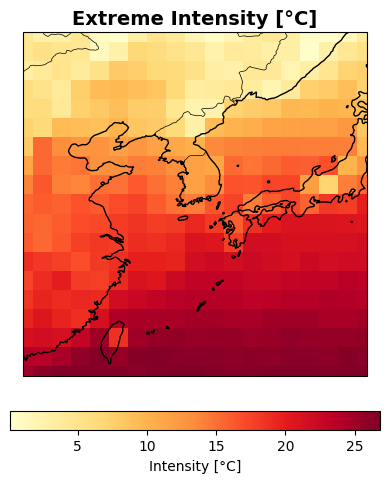

In [ ]:
# Plot: 발생 강도
plt.figure(figsize=(4,5))
proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)
# Kelvin → Celsius 변환
im = intensity_sub_C.plot(
    ax=ax,
    transform=proj,
    cmap='YlOrRd',
    cbar_kwargs={
        'label': 'Intensity [°C]',
        'orientation': 'horizontal',
        'pad': 0.08
    }
)
ax.coastlines(resolution='50m', linewidth=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([114, 141, 21, 48], crs=proj)
ax.set_title('Extreme Intensity [°C]', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(out_fileName2, dpi=300, bbox_inches='tight')
plt.show()